In [3]:
from utils.load_results import *
from utils.plot_helpers import *

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('default')

In [4]:
datasets = ['(3,16)', '(4,4)', '(5,4)']
n_values = [16, 4, 4]
n_attributes = [3, 4, 5]
n_epochs = 100
n_runs = 3
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_3' for d in datasets]

In [5]:
context_unaware = False # whether original or context_unaware simulations are evaluated
no_cost = False # set to True to consider baselines without a cost
if context_unaware and not no_cost:
    setting = 'context_unaware'
elif context_unaware and no_cost:
    setting = 'no_cost_context_unaware'
elif not context_unaware and not no_cost:
    setting = 'context_aware'
else:
    setting = 'no_cost_context_aware'

### Todo: modify for length cost

## training

In [6]:
result_dict = {'train_acc': [], 'val_acc': [], 'test_acc': [], 'train_loss': [], 'val_loss': [], 'test_loss': [], 'train_message_length': [], 'val_message_length': []}
    
for path_idx, path in enumerate(paths):

    train_accs = []
    val_accs = []
    test_accs = []
    train_losses = []
    val_losses = []
    test_loss = []
    train_message_lengths = []
    val_message_lengths = []

    for run in range(n_runs):
        
        length_cost_path = path + '/length_cost/' + setting + '/' + str(run) + '/'
        
        data = pickle.load(open(length_cost_path + 'loss_and_metrics.pkl', 'rb'))
        # accuracies
        lists = sorted(data['metrics_train0'].items())
        _, train_acc = zip(*lists)
        train_accs.append(train_acc)
        lists = sorted(data['metrics_test0'].items()) 
        _, val_acc = zip(*lists)
        val_accs.append(val_acc)
        test_accs.append(data['final_test_acc'])
        
        # losses
        lists = sorted(data['loss_train'].items())
        _, train_loss = zip(*lists)
        train_losses.append(train_loss)
        lists = sorted(data['loss_test'].items())
        _, val_loss = zip(*lists)
        val_losses.append(val_loss)
        test_loss.append(data['final_test_loss'])
        
        # message lengths
        lists = sorted(data['metrics_train1'].items())
        _, train_message_length = zip(*lists)
        train_message_lengths.append(train_message_length)
        lists = sorted(data['metrics_test1'].items()) 
        _, val_message_length = zip(*lists)
        val_message_lengths.append(val_message_length)

    result_dict['train_acc'].append(train_accs)
    result_dict['val_acc'].append(val_accs)
    result_dict['test_acc'].append(test_accs)
    result_dict['train_loss'].append(train_losses)
    result_dict['val_loss'].append(val_losses)
    result_dict['test_loss'].append(test_loss)
    result_dict['train_message_length'].append(train_message_lengths)
    result_dict['val_message_length'].append(val_message_lengths)

for key in result_dict.keys():
    result_dict[key] = np.array(result_dict[key])

all_accuracies = result_dict

FileNotFoundError: [Errno 2] No such file or directory: 'results/(3,16)_game_size_10_vsf_3/length_cost/context_aware/0/loss_and_metrics.pkl'

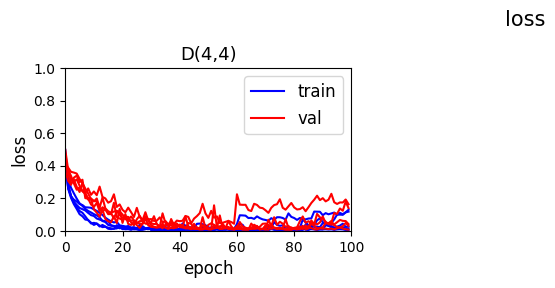

In [184]:
plot_training_trajectory(all_accuracies['train_loss'], all_accuracies['val_loss'], ylim=(0, 1), xlim=(0, 100), steps=(1, 1), #message_length_train=all_accuracies['train_message_length'], message_length_val=all_accuracies['val_message_length'], 
train_only=False, loss_plot=True, n_epochs=100, titles=('D(4,4)',), plot_indices=(1,), figsize=(10,7))

In [1]:
all_accuracies['train_message_length']

NameError: name 'all_accuracies' is not defined

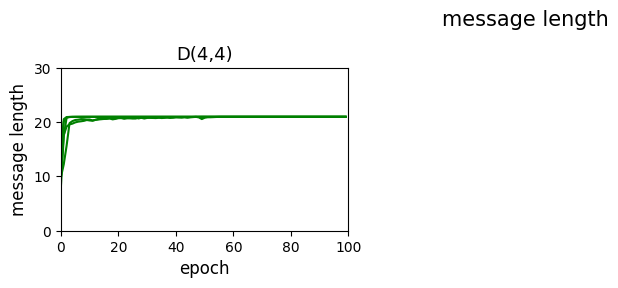

In [159]:
plot_training_trajectory(results_train=None, results_val=None, ylim=(0, 30), xlim=(0, 100), steps=(1, 1), message_length_train=all_accuracies['train_message_length'], 
train_only=True, message_length_plot=True, n_epochs=100, titles=('D(4,4)',), plot_indices=(1,))

## final accuracies 

In [137]:
accuracies = [all_accuracies['train_acc'], all_accuracies['val_acc']]

In [138]:
# get accuracy means and sds for table representation
final_accuracies_train = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies['train_acc'][i][run][-1])
    final_accuracies_train[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_train

{'(4,4)': (0.98, 0.02)}

In [139]:
final_accuracies_val = {}
for i, d in enumerate(datasets):
    gather_accuracies = []
    for run in range(5):
        gather_accuracies.append(all_accuracies['val_acc'][i][run][-1])
    final_accuracies_val[d] = (round(np.mean(gather_accuracies), 3), round(np.std(gather_accuracies), 3))
final_accuracies_val

{'(4,4)': (0.974, 0.025)}

IndexError: index 1 is out of bounds for axis 0 with size 1

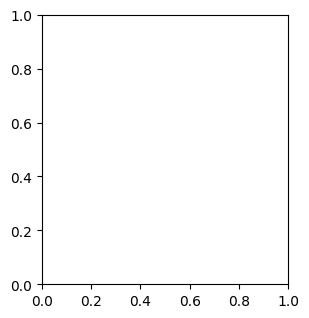

In [140]:
plot_heatmap(accuracies, 'mean', plot_dims=(1,2), ylims=(0.4, 1.0), figsize=(7, 3.5), suptitle='accuracies', 
             fontsize=17, titles=('length cost \ntrain', 'length cost \n validation'))

## entropy scores 
### context-aware

In [168]:
entropy_scores = load_entropies(paths, length_cost=None)
entropies = [entropy_scores['NMI'], entropy_scores['effectiveness'], entropy_scores['consistency']]

In [169]:
entropy_dict = {}
for i, score in enumerate(list(entropy_scores.keys())[:3]):
    results = entropies[i]
    mean = np.nanmean(results, axis=-1)
    sd = np.std(results, axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict[d + score] = (round(mean[idx], 3), round(sd[idx], 3))
entropy_dict


{'(4,4)NMI': (0.91, 0.014),
 '(4,4)effectiveness': (0.958, 0.017),
 '(4,4)consistency': (0.867, 0.015)}

In [170]:
# from generic to specific
entropies_hierarchical = [entropy_scores['NMI_hierarchical'], entropy_scores['effectiveness_hierarchical'], entropy_scores['consistency_context_dep']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[3:6]):
    results = entropies_hierarchical[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])
entropy_dict_context_dep


{'(4,4)NMI_hierarchical': array([0.9051449 , 0.93036045, 0.89836661, 0.92741849, 0.90972004]),
 '(4,4)effectiveness_hierarchical': array([0.98034022, 0.99831791, 0.99177414, 0.99622891, 0.99753317]),
 '(4,4)consistency_hierarchical': array([0.91526968, 0.91767099, 0.89429301, 0.91724527, 0.91351485])}

In [171]:
# from coarse to fine context
entropies_context_dep = [entropy_scores['NMI_context_dep'], entropy_scores['effectiveness_context_dep'], entropy_scores['consistency_context_dep']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[6:9]):
    results = entropies_context_dep[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])
entropy_dict_context_dep


{'(4,4)NMI_context_dep': array([0.93150083, 0.94892887, 0.92911907, 0.94620398, 0.94673758]),
 '(4,4)effectiveness_context_dep': array([0.94834006, 0.98241488, 0.96678389, 0.9770509 , 0.98247422]),
 '(4,4)consistency_context_dep': array([0.91526968, 0.91767099, 0.89429301, 0.91724527, 0.91351485])}

In [172]:
# from generic&coarse to specific&fine
entropies_concept_x_context = [entropy_scores['NMI_concept_x_context'], entropy_scores['effectiveness_concept_x_context'], entropy_scores['consistency_concept_x_context']]
entropy_dict_conc_x_cont = {}
for i, score in enumerate(list(entropy_scores.keys())[9:]):
    results = entropies_context_dep[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_conc_x_cont[d + score] = mean[idx] #(mean[idx], sd[idx])
entropy_dict_conc_x_cont

{'(4,4)NMI_concept_x_context': array([0.93150083, 0.94892887, 0.92911907, 0.94620398, 0.94673758]),
 '(4,4)effectiveness_concept_x_context': array([0.94834006, 0.98241488, 0.96678389, 0.9770509 , 0.98247422]),
 '(4,4)consistency_concept_x_context': array([0.91526968, 0.91767099, 0.89429301, 0.91724527, 0.91351485])}

IndexError: index 1 is out of bounds for axis 0 with size 1

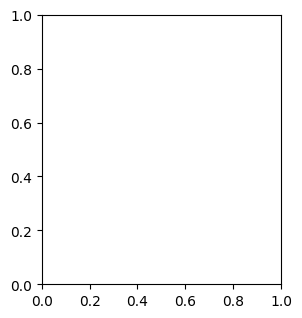

In [82]:
plot_heatmap(entropies, 'mean', plot_dims=(1,3), ylims=(0.8, 1.0), figsize=(10.5, 3.5), 
             titles = ('NMI', 'effectiveness', 'consistency'), suptitle='entropy scores')

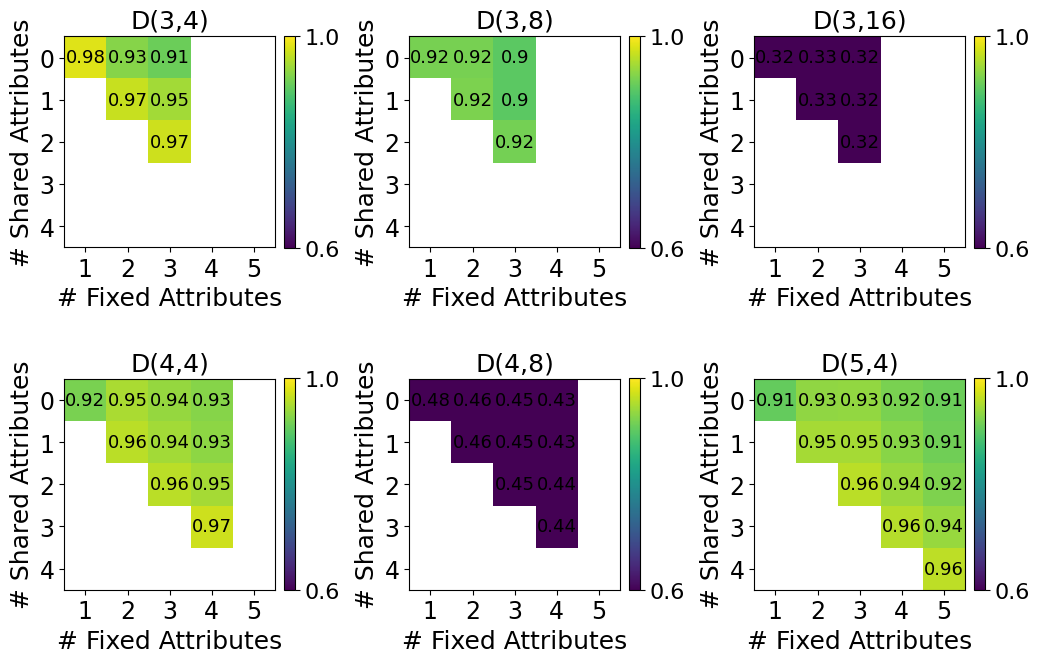

In [17]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='NMI', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), inner_fontsize_fctr=-5)

In [173]:
data_list, run_list, level_list = [], [], []
NMI_hierarchical, effectiveness_hierarchical, consistency_hierarchical = [], [], []

for d, data in enumerate(datasets):
    for run in range(5):
        
        scores = pickle.load(open(paths[d] + '/length_cost/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
                effectiveness_hierarchical.append(scores['effectiveness_hierarchical'][l])
                consistency_hierarchical.append(scores['consistency_hierarchical'][l])
            except: 
                NMI_hierarchical.append(np.nan)
                effectiveness_hierarchical.append(np.nan)
                consistency_hierarchical.append(np.nan)

entropy_dict_hierarchical = {'data': data_list, 'level': level_list, 'run': run_list, 'NI': NMI_hierarchical, 
                             'effectiveness': effectiveness_hierarchical, 'consistency': consistency_hierarchical}


In [174]:
all_hierarchical = {}
all_hierarchical['metric'] = ['NI'] * 25 + ['effectiveness'] * 25 + ['consistency'] * 25 # change to 25 for one dataset
all_hierarchical['value'] = (entropy_dict_hierarchical['NI'] + 
                             entropy_dict_hierarchical['effectiveness'] + 
                             entropy_dict_hierarchical['consistency'])
all_hierarchical['level'] = entropy_dict_hierarchical['level'] * 3

/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: Al

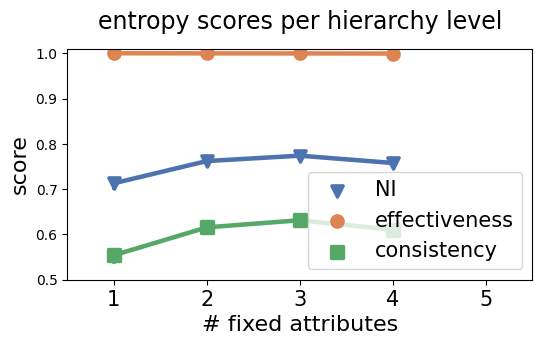

In [175]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_hierarchical, hue='metric', 
                   markers=['v', 'o', 's'], palette='deep', scale=1.2)
plt.ylabel('score', fontsize=16)
plt.title('entropy scores per hierarchy level', fontsize=17, y=1.05)
plt.ylim([0.5,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5])
#plt.yticks(ticks=[0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('# fixed attributes', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.show()

In [176]:
data_list, run_list, level_list = [], [], []
NMI_context_dep, effectiveness_context_dep, consistency_context_dep = [], [], []

for d, data in enumerate(datasets):
    for run in range(5):
        
        scores = pickle.load(open(paths[d] + '/length_cost/' + setting + '/' + str(run) + '/entropy_scores.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_context_dep.append(scores['normalized_mutual_info_context_dep'][l])
                effectiveness_context_dep.append(scores['effectiveness_context_dep'][l])
                consistency_context_dep.append(scores['consistency_context_dep'][l])
            except: 
                NMI_context_dep.append(np.nan)
                effectiveness_context_dep.append(np.nan)
                consistency_context_dep.append(np.nan)

entropy_dict_context_dep = {'data': data_list, 'level': level_list, 'run': run_list, 'NMI': NMI_context_dep, 
                             'effectiveness': effectiveness_context_dep, 'consistency': consistency_context_dep}


In [177]:
all_context_dep = {}
all_context_dep['metric'] = ['NMI'] * 25 + ['effectiveness'] * 25 + ['consistency'] * 25
all_context_dep['value'] = (entropy_dict_context_dep['NMI'] + 
                             entropy_dict_context_dep['effectiveness'] + 
                             entropy_dict_context_dep['consistency']
                            )
all_context_dep['level'] = entropy_dict_context_dep['level'] * 3

/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: Al

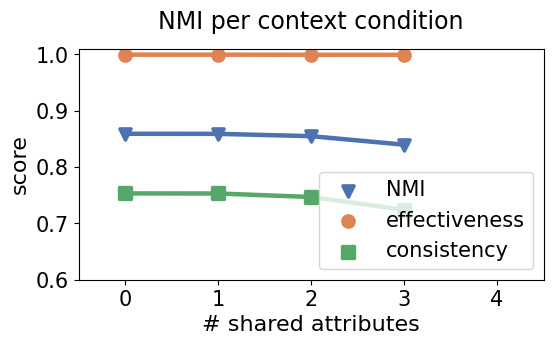

In [178]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_context_dep, hue='metric', 
                   markers=['v', 'o', 's'], palette='deep', scale=1.2)
plt.ylabel('score', fontsize=16)
plt.title('NMI per context condition', fontsize=17, y=1.05)
plt.ylim([0.6,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[0,1,2,3,4])
plt.yticks(ticks=[0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('# shared attributes', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.show()

## message length and symbol redundancy

In [147]:
ml_dict = {'level': [], 'data set': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        # if evaluated after training from interaction this is an array showing the message length
        # per level of concreteness (most abstract --> most concrete)
        ml_hierarchical = pickle.load(open(paths[d] + '/length_cost/' + setting + '/' + str(run) + 
                                           '/message_length_hierarchical.pkl', 'rb'))
        
        # if evaluated with the callback throughout training, you get an array for each epoch
        if isinstance(ml_hierarchical, dict): 
            ml_hierarchical = ml_hierarchical['message_length_train'][n_epochs]
            
        for level in range(5):
            
            ml_dict['level'].append(level)
            ml_dict['run'].append(run)
            ml_dict['data set'].append(dataset)
            try: 
                ml_dict['message length'].append(ml_hierarchical[level])
            except: 
                ml_dict['message length'].append(np.NaN)

FileNotFoundError: [Errno 2] No such file or directory: 'results/(4,4)_game_size_10_vsf_3/length_cost/no_cost_context_unaware/0/message_length_hierarchical.pkl'

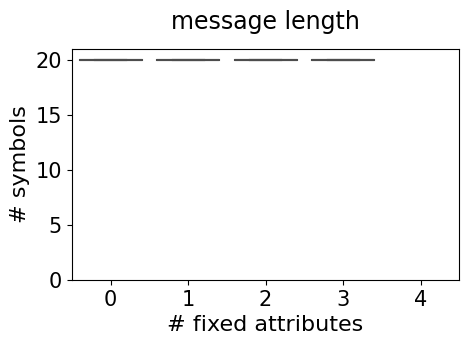

In [123]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='message length', data=ml_dict, color='gray')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,21)
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('# symbols', fontsize=16)
plt.title('message length', fontsize=17, y=1.05)
plt.show()

In [148]:
symbol_redundancy_dict = {'level': [], 'data set': [], 'run': [], 'symbol frequency': []}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        scores = pickle.load(open(paths[d]  + '/length_cost/' + setting + '/' + str(run) + '/symbol_redundancy.pkl', 'rb'))
            
        for level in range(5):
            
            symbol_redundancy_dict['level'].append(level)
            symbol_redundancy_dict['run'].append(run)
            symbol_redundancy_dict['data set'].append(dataset)
            try: 
                symbol_redundancy_dict['symbol frequency'].append(scores['symbol_redundancy'][level])
            except: 
                symbol_redundancy_dict['symbol frequency'].append(np.NaN)

FileNotFoundError: [Errno 2] No such file or directory: 'results/(4,4)_game_size_10_vsf_3/length_cost/no_cost_context_unaware/0/symbol_redundancy.pkl'

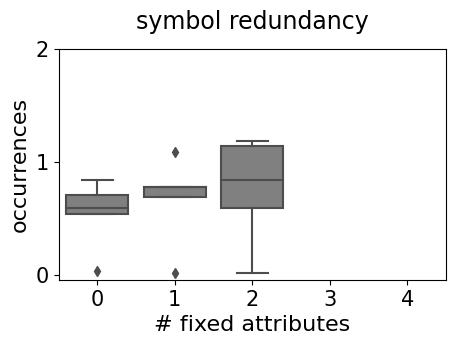

In [132]:
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='symbol frequency', data=symbol_redundancy_dict, color='gray')
plt.xticks(ticks=[0,1,2,3,4], labels=[0,1,2,3,4], fontsize=15)
plt.yticks(ticks=[0, 1, 2], fontsize=15)
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('occurrences', fontsize=16)
plt.title('symbol redundancy', fontsize=17, y=1.05)
plt.show()

## compositionality

In [166]:
topsim, posdis, bosdis = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_specific, posdis_specific, bosdis_specific = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        topsim_score = pickle.load(open(paths[d] + '/length_cost/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent_score = pickle.load(open(paths[d] + '/length_cost/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        topsim[d, run] = topsim_score['topsim_train']
        posdis[d, run] = disent_score['posdis']
        bosdis[d, run] = disent_score['bosdis']
        topsim_specific[d, run] = topsim_score['topsim_specific_train']
        posdis_specific[d, run] = disent_score['posdis_specific']
        bosdis_specific[d, run] = disent_score['bosdis_specific']

FileNotFoundError: [Errno 2] No such file or directory: 'results/(4,4)_game_size_10_vsf_3/length_cost/no_cost_context_unaware/0/topsim_final.pkl'

In [152]:
for i, d in enumerate(datasets):
    print(d, "topsim:", round(np.mean(topsim[i]), 3), "sd", round(np.std(topsim[i]), 2))
    print(d, "posdis", round(np.mean(posdis[i]), 3), "sd", round(np.std(posdis[i]), 2))
    print(d, "bosdis", round(np.mean(bosdis[i]), 3), "sd", round(np.std(bosdis[i]), 2))

(4,4) topsim: 0.0 sd 0.0
(4,4) posdis 0.0 sd 0.0
(4,4) bosdis 0.0 sd 0.0


IndexError: index 1 is out of bounds for axis 0 with size 1

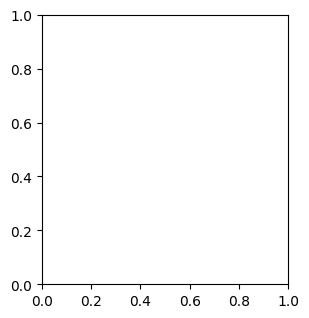

In [8]:
plot_heatmap([topsim, topsim_specific], 'mean', plot_dims=(1,2), ylims=[0.0,0.65], figsize=(7,3.5), 
             titles=['all concepts', 'specific concepts'], suptitle='topographic similarity', suptitle_position=1.)

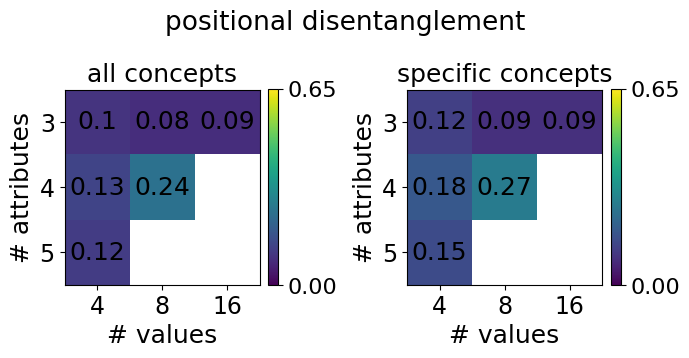

In [33]:
plot_heatmap([posdis, posdis_specific], 'mean', plot_dims=(1,2), ylims=[0.0,0.65], figsize=(7,3.5),
             titles=['all concepts', 'specific concepts'], suptitle='positional disentanglement', suptitle_position=1.)

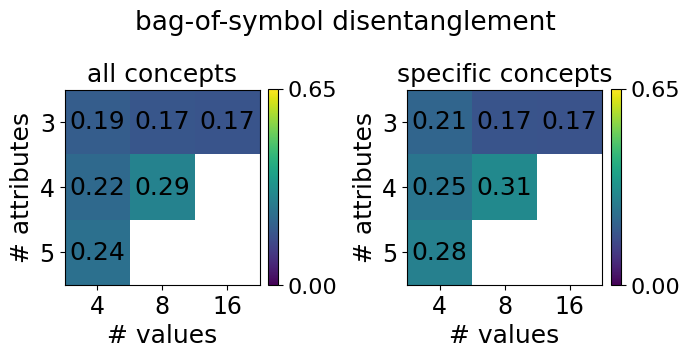

In [34]:
plot_heatmap([bosdis, bosdis_specific], 'mean', plot_dims=(1,2), ylims=[0.0,0.65], figsize=(7,3.5),
             titles=['all concepts', 'specific concepts'], suptitle='bag-of-symbol disentanglement', suptitle_position=1.)

In [155]:
bosdis = []

for d, dataset in enumerate(datasets): 
    sublist = []
    for run in range(5):
        sublist.append(pickle.load(open(paths[d] + '/length_cost/' + setting + '/' + str(run) + '/bosdis_scores.pkl', 'rb')))
    bosdis.append(sublist)

/Users/kkobrock/Projects/phdproject1/emergent-abstractions/utils/plot_helpers.py:141: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


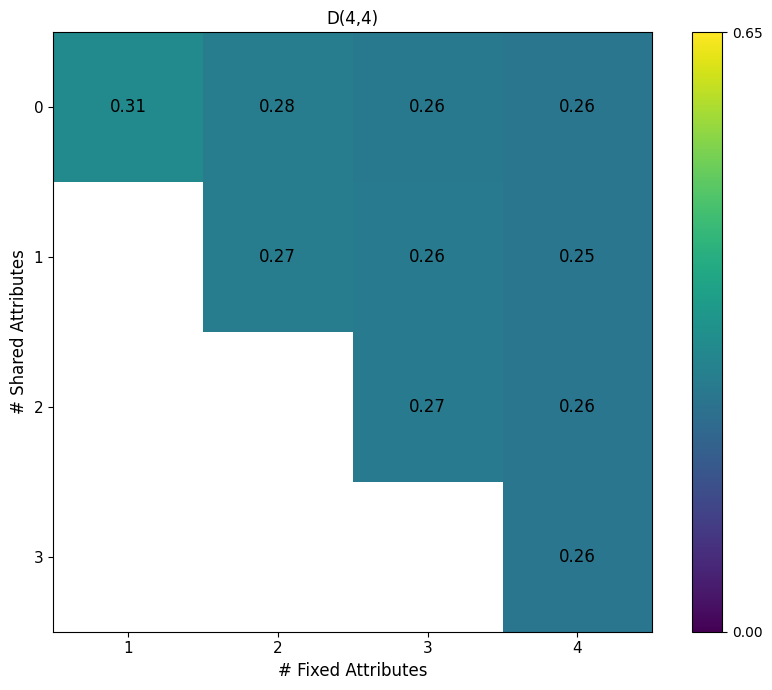

In [156]:
plot_heatmap_concept_x_context(bosdis, score='bosdis', mode='mean', plot_dims=(1,1), heatmap_size=(4,4), 
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,0.65), titles=('D(4,4)',), one_dataset=True, attributes=4)

In [129]:
# compositionality scores for each data set

compositionality_scores = {'dataset':[], 'run':[], 'metric':[], 'data':[], 'score':[]}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        topsim = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        
        for metric in ['topsim', 'posdis', 'bosdis']:
            #for data in ['all', 'concrete']: 
            for data in ['all']:
                
                compositionality_scores['dataset'].append(dataset)
                compositionality_scores['run'].append(run)
                compositionality_scores['metric'].append(metric)
                compositionality_scores['data'].append(data)
                
                append = '' if data == 'all' else '_max_relevance'
                    
                if metric == 'topsim':
                    compositionality_scores['score'].append(topsim['topsim' + append + '_train'])
                if metric == 'posdis':
                    compositionality_scores['score'].append(disent['posdis' + append])
                if metric == 'bosdis':
                    compositionality_scores['score'].append(disent['bosdis' + append])

compositionality_scores = pd.DataFrame(compositionality_scores)

FileNotFoundError: [Errno 2] No such file or directory: 'results/(4,4)_game_size_10_vsf_3/no_cost_context_aware/0/topsim_final.pkl'

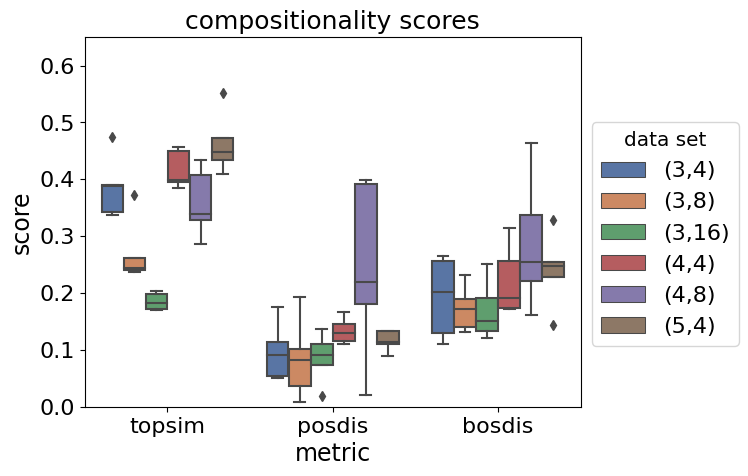

In [40]:
sns.boxplot(x='metric', y='score', data=compositionality_scores[compositionality_scores.data=='all'], 
            hue='dataset', palette='deep')
plt.xlabel(xlabel='metric', fontsize=17)
plt.ylabel(ylabel='score', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=16)
plt.ylim(0, 0.65)
legend = plt.legend(fontsize=16, title='data set', bbox_to_anchor=(1., 0.8))
plt.setp(legend.get_title(),fontsize='x-large')
plt.title('compositionality scores', fontsize=18)
plt.show()

In [ ]:
# Not done (yet)
# compositionality scores for different vocab size factors 

compositionality_scores = {'vs factor':[], 'run':[], 'metric':[], 'score':[]}

for vsf in [1, 2, 3, 4]: 
    for run in range(5):
        
        path = 'results/(4,8)_sample_scaling_10_balanced_False_vsf_' + str(vsf) + '/'
        
        topsim = pickle.load(open(path + 'standard/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent = pickle.load(open(path + 'standard/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        
        for metric in ['topsim', 'posdis', 'bosdis']:
                
                compositionality_scores['vs factor'].append(vsf)
                compositionality_scores['run'].append(run)
                compositionality_scores['metric'].append(metric)

                if metric == 'topsim':
                    compositionality_scores['score'].append(topsim['topsim_train'])
                if metric == 'posdis':
                    compositionality_scores['score'].append(disent['posdis'])
                if metric == 'bosdis':
                    compositionality_scores['score'].append(disent['bosdis'])

compositionality_scores = pd.DataFrame(compositionality_scores)

## co-occurrences

In [ ]:
# Not done (yet)
full_plot = False

fig = plt.figure(figsize=(12,3))

for d, dim in enumerate(datasets): 
    
    data = datasets[d]
    path = paths[d]
    vs_factor = int(path[-2])
    vocab_size = (n_values[d] + 1) * vs_factor + 1
    colors = plt.cm.jet(np.linspace(0,1,vocab_size))
    
    average_cooccurences = []
    
    plt.subplot(1,6,d+1)
    
    for run in range(5):
        
        cooccurences = pickle.load(open(paths[d] + 'standard/' + str(run) + '/normalized_cooccurrence.pkl', 'rb'))
        indices = np.flip(np.argsort(cooccurences[:,-1]))
        cooccurences = cooccurences[indices]
        average_cooccurences.append(cooccurences)
        
    average_cooccurences = np.flip(np.mean(average_cooccurences, axis=0), axis=1)
    
    data_dict = {}
    data_dict['symbol rank'] = []
    data_dict['level'] = []
    data_dict['value'] = []
    for symbol in indices:
        for level in range(average_cooccurences.shape[1]):
            data_dict['symbol rank'].append(symbol+1)
            data_dict['level'].append(level)
            data_dict['value'].append(average_cooccurences[symbol, level])
    
    if full_plot:
        g = sns.heatmap(average_cooccurences, cmap='viridis')
        plt.yticks(ticks=[0.5,vocab_size-1.5], labels=[1,vocab_size], fontsize=14)
    else: 
        g = sns.heatmap(average_cooccurences[0:10,:], cmap='viridis')
        plt.yticks(ticks=[0.5,9.5], labels=[1,10], fontsize=14, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=13)
    for _, spine in g.spines.items():
        spine.set_visible(True)
    #plt.xlabel('# relevant attributes', fontsize=14)
    #plt.ylabel('symbol rank', fontsize=14)
    plt.xticks(ticks=np.arange(n_attributes[d])+0.5, labels=range(1,n_attributes[d]+1), fontsize=14)
    plt.title(data, fontsize=14)
    
    fig.text(0.5, -0.05, '# relevant attributes', ha='center', va='center', fontsize=15, alpha=0.3)
    fig.text(-0.01, 0.5, 'symbol rank', ha='center', va='center', rotation='vertical', fontsize=15, alpha=0.3)

plt.tight_layout()

#### Bootstrapping Confidence Intervals

In [ ]:
# how to bootstrap CIs
from scipy.stats import bootstrap
rng = np.random.default_rng()
from scipy.stats import norm
dist = norm(loc=2, scale=4)  # our "unknown" distribution
data = dist.rvs(size=100, random_state=rng)
print(data)
data = (data,)
print(type(data[0]))
res = bootstrap(data, np.std, confidence_level=0.9, random_state=rng, n_resamples=1000, method='basic')
res